# Modeling - Retail Forecasting

## Pre-Work

### Import Modules and Data

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os
import pickle
import warnings
import dataframe_image as dfi

# Cross-validation modules
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
# Turn off setting with copy warning
pd.set_option('mode.chained_assignment', None)

In [3]:
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [4]:
# Change directory
os.chdir('../data/processed')

In [5]:
# Load data
X_train0 = pd.read_csv('X_train0.csv')
y_train0 = pd.read_csv('y_train0.csv')
X_test0 = pd.read_csv('X_test0.csv')
y_test0 = pd.read_csv('y_test0.csv')
cvX_train0 = pickle.load(open("cvX_train0", "rb"))
cvy_train0 = pickle.load(open("cvy_train0", "rb"))
cvX_test0 = pickle.load(open("cvX_test0", "rb"))
cvy_test0 = pickle.load(open ("cvy_test0", "rb"))

X_train1 = pd.read_csv('X_train1.csv')
y_train1 = pd.read_csv('y_train1.csv')
X_test1 = pd.read_csv('X_test1.csv')
y_test1 = pd.read_csv('y_test1.csv')
cvX_train1 = pickle.load(open("cvX_train1", "rb"))
cvy_train1 = pickle.load(open("cvy_train1", "rb"))
cvX_test1 = pickle.load(open("cvX_test1", "rb"))
cvy_test1 = pickle.load(open("cvy_test1", "rb"))

X_train2 = pd.read_csv('X_train2.csv')
y_train2 = pd.read_csv('y_train2.csv')
X_test2 = pd.read_csv('X_test2.csv')
y_test2 = pd.read_csv('y_test2.csv')
cvX_train2 = pickle.load(open("cvX_train2", "rb"))
cvy_train2 = pickle.load(open("cvy_train2", "rb"))
cvX_test2 = pickle.load(open("cvX_test2", "rb"))
cvy_test2 = pickle.load(open("cvy_test2", "rb"))

## Define Functions

In [6]:
# Will use sklearn's time series cv split in GridSearchCV and RandomizedSearchCVs
tscv = TimeSeriesSplit(n_splits=5)

In [7]:
# Define GridSearchCV Function to use in addition to the CV function I build
def GSCV(reg, param_grid, store):
    if store == 0:
        X_train, y_train, X_test, y_test = X_train0, y_train0, X_test0, y_test0
    elif store == 1:
        X_train, y_train, X_test, y_test = X_train1, y_train1, X_test1, y_test1
    else:
        X_train, y_train, X_test, y_test = X_train2, y_train2, X_test2, y_test2
        
    gscv = GridSearchCV(estimator=reg, cv=tscv, param_grid=param_grid, \
                        scoring='neg_root_mean_squared_error')
    gscv.fit(X_train, np.ravel(y_train))
    print('Best parameters are ' + str(gscv.best_params_))
    print('Best RMSE score is ' + str(round(-gscv.best_score_)))    

In [8]:
# Define RandomizedSearchCV Function as well to use with the more computationally intenstive algorithms
def RSCV(reg, param_dist, store, n_iter=10):
    if store == 0:
        X_train, y_train, X_test, y_test = X_train0, y_train0, X_test0, y_test0
    elif store == 1:
        X_train, y_train, X_test, y_test = X_train1, y_train1, X_test1, y_test1
    else:
        X_train, y_train, X_test, y_test = X_train2, y_train2, X_test2, y_test2
        
    rscv = RandomizedSearchCV(estimator=reg, n_iter=n_iter, cv=tscv, param_distributions=param_dist, \
                        scoring='neg_root_mean_squared_error')
    rscv.fit(X_train, np.ravel(y_train))
    print('Best parameters are ' + str(rscv.best_params_))
    print('Best RMSE score is ' + str(round(-rscv.best_score_)))    

In [9]:
# Build function for cross-validation modeling
def cvmodeling(model, X_train, y_train, X_test, y_test, table=False):
    
    # Instantiate empty lists
    cvnum = []
    R2_train = []
    R2_test = []
    RMSE_test = []
    
    # For loop to collect parameters
    for i in range(5):
        reg = model
        reg.fit(X_train[i], np.ravel(y_train[i]))
        y_pred = reg.predict(X_test[i])
        cvnum.append(i+1)
        R2_train.append(round(reg.score(X_train[i], np.ravel(y_train[i])), 4))
        R2_test.append(round(r2_score(y_test[i], y_pred), 4))
        RMSE_test.append(round(mean_squared_error(y_test[i], y_pred, squared=False), 4))
    
    summary = pd.DataFrame({'CV_num':cvnum, 'R2_train_score':R2_train, 'R2_test_score':R2_test, 'RMSE_test_score':RMSE_test})
    if table == True:
        print(summary)
    print('Mean CV R2 training score = ' + str(round(summary.R2_train_score.mean(), 4)))
    print('Mean CV R2 testing score = ' + str(round(summary.R2_test_score.mean(), 4)))
    print('Mean CV Root-mean-squared test score = ' + str(round(summary.RMSE_test_score.mean())))

## Modeling


### Linear Regression

#### Define Model Specific Functions

In [33]:
# Define function for linear regression cross validation
def linregCV(store, table=False):
        linreg = LinearRegression()
        print('LinearRegression - CV - Store Type ' + str(store))
        if store == 0:
            X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
        elif store ==1:
            X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
        else:
            X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
            
        cvmodeling(linreg, X_train, y_train, X_test, y_test, table)
        print('\n')

#### Store Type 0

In [34]:
%%time
# Linear Regression CV on Store Type 0
linregCV(0, True)

LinearRegression - CV - Store Type 0
   CV_num  R2_train_score  R2_test_score  RMSE_test_score
0       1          0.8966  -3.791204e+24     3.004639e+16
1       2          0.9000  -6.480850e+23     1.264206e+16
2       3          0.9018  -1.313542e+22     1.798878e+15
3       4          0.9024  -6.076139e+21     1.241335e+15
4       5          0.9018  -5.293005e+21     1.175911e+15
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = -8.927586343701596e+23
Mean CV Root-mean-squared test score = 9380916230047378


Wall time: 898 ms


#### Store Type 1

In [35]:
%%time
# Linear Regression CV on Store Type 1
linregCV(1, True)

LinearRegression - CV - Store Type 1
   CV_num  R2_train_score  R2_test_score  RMSE_test_score
0       1          0.6331  -2.067003e+24     2.292225e+16
1       2          0.6427  -7.095726e+24     4.241503e+16
2       3          0.6517  -5.730013e+20     3.688910e+14
3       4          0.6575  -3.389901e+24     2.880930e+16
4       5          0.6643  -7.754588e+22     5.542422e+15
Mean CV R2 training score = 0.6499
Mean CV R2 testing score = -2.5261497983843974e+24
Mean CV Root-mean-squared test score = 20011577119268792


Wall time: 3.95 s


#### Store Type 2

In [36]:
%%time
# Linear Regression CV on Store Type 2
linregCV(2, True)

LinearRegression - CV - Store Type 2
   CV_num  R2_train_score  R2_test_score  RMSE_test_score
0       1          0.7888  -3.126525e+24     4.424536e+16
1       2          0.7952  -7.820331e+24     7.153989e+16
2       3          0.8003  -9.655305e+21     2.484896e+15
3       4          0.8040  -3.452033e+24     4.804678e+16
4       5          0.8080  -1.094594e+24     2.998432e+16
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = -3.1006275775466636e+24
Mean CV Root-mean-squared test score = 39260248553684576


Wall time: 5.73 s


### Ridge Regression

#### Define Model Specific Functions

In [41]:
# Define function for performing ridge regression cross validation for tuning of alpha
def ridgeregCV(store, alphas, table=False):
    for i in alphas:
        ridgereg = Ridge(random_state=42, alpha=i)
        print('Ridge Regression - CV - alpha=' + str(i) + ' - Store Type ' + str(store))
        if store == 0:
            X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
        elif store ==1:
            X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
        else:
            X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
            
        cvmodeling(ridgereg, X_train, y_train, X_test, y_test, table)
        print('\n')

#### Store Type 0

In [42]:
%%time
ridgeregCV(0, [0.001, 0.01, 0.1, 1, 10, 100, 1000])

Ridge Regression - CV - alpha=0.001 - Store Type 0
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = 0.9051
Mean CV Root-mean-squared test score = 4862


Ridge Regression - CV - alpha=0.01 - Store Type 0
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = 0.9054
Mean CV Root-mean-squared test score = 4854


Ridge Regression - CV - alpha=0.1 - Store Type 0
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = 0.9061
Mean CV Root-mean-squared test score = 4836


Ridge Regression - CV - alpha=1 - Store Type 0
Mean CV R2 training score = 0.9005
Mean CV R2 testing score = 0.9061
Mean CV Root-mean-squared test score = 4836


Ridge Regression - CV - alpha=10 - Store Type 0
Mean CV R2 training score = 0.8995
Mean CV R2 testing score = 0.9038
Mean CV Root-mean-squared test score = 4896


Ridge Regression - CV - alpha=100 - Store Type 0
Mean CV R2 training score = 0.8581
Mean CV R2 testing score = 0.8555
Mean CV Root-mean-squared test score = 5998


Ridge Regression

In [57]:
# Compare results with GridSearchCV
param_grid = {'alpha':[0.00, 0.01, 0.1, 1, 10, 100, 1000]}
GSCV(Ridge(), param_grid, 0)

Best parameters are {'alpha': 0.1}
Best score is 0.8988


#### Store Type 1

In [48]:
%%time
ridgeregCV(1, [0.001, 0.01, 0.1, 1, 10, 100, 1000])

Ridge Regression - CV - alpha=0.001 - Store Type 1
Mean CV R2 training score = 0.65
Mean CV R2 testing score = 0.6559
Mean CV Root-mean-squared test score = 9718


Ridge Regression - CV - alpha=0.01 - Store Type 1
Mean CV R2 training score = 0.65
Mean CV R2 testing score = 0.6579
Mean CV Root-mean-squared test score = 9693


Ridge Regression - CV - alpha=0.1 - Store Type 1
Mean CV R2 training score = 0.65
Mean CV R2 testing score = 0.6678
Mean CV Root-mean-squared test score = 9572


Ridge Regression - CV - alpha=1 - Store Type 1
Mean CV R2 training score = 0.6499
Mean CV R2 testing score = 0.6767
Mean CV Root-mean-squared test score = 9456


Ridge Regression - CV - alpha=10 - Store Type 1
Mean CV R2 training score = 0.6492
Mean CV R2 testing score = 0.6805
Mean CV Root-mean-squared test score = 9405


Ridge Regression - CV - alpha=100 - Store Type 1
Mean CV R2 training score = 0.642
Mean CV R2 testing score = 0.6825
Mean CV Root-mean-squared test score = 9380


Ridge Regression - CV -

In [58]:
# Compare results with GridSearchCV
param_grid = {'alpha':[0.00, 0.01, 0.1, 1, 10, 100, 1000]}
GSCV(Ridge(), param_grid, 1)

Best parameters are {'alpha': 1}
Best score is 0.6364


#### Store Type 2

In [50]:
%%time
ridgeregCV(2, [0.001, 0.01, 0.1, 1, 10, 100, 1000])

Ridge Regression - CV - alpha=0.001 - Store Type 2
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = 0.8166
Mean CV Root-mean-squared test score = 11174


Ridge Regression - CV - alpha=0.01 - Store Type 2
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = 0.8168
Mean CV Root-mean-squared test score = 11169


Ridge Regression - CV - alpha=0.1 - Store Type 2
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = 0.8173
Mean CV Root-mean-squared test score = 11151


Ridge Regression - CV - alpha=1 - Store Type 2
Mean CV R2 training score = 0.7993
Mean CV R2 testing score = 0.8177
Mean CV Root-mean-squared test score = 11141


Ridge Regression - CV - alpha=10 - Store Type 2
Mean CV R2 training score = 0.799
Mean CV R2 testing score = 0.8176
Mean CV Root-mean-squared test score = 11145


Ridge Regression - CV - alpha=100 - Store Type 2
Mean CV R2 training score = 0.7936
Mean CV R2 testing score = 0.8117
Mean CV Root-mean-squared test score = 11324


Ridge Regre

In [59]:
# Compare Results with GridSearchCV
param_grid = {'alpha':[0.00, 0.01, 0.1, 1, 10, 100, 1000]}
GSCV(Ridge(), param_grid, 2)

Best parameters are {'alpha': 1}
Best score is 0.7844


### Random Forest

#### Define Model Specific Functions

In [9]:
# Define function for performing random forest cross validation for tuning of max_depth

def rfCV(store, tuneparam=None, param_value=None, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
         min_weight_fraction_leaf=0, n_jobs=-1, max_features='auto', table=False):
    if param_value == None:
        
        rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split, \
                                      min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction, \
                                      max_features=max_features, n_jobs=n_jobs)
        
        print('Random Forest Regression - CV - Store Type ' + str(store))
        print('max_depth = ' + str(max_depth))
        print('min_samples_split = ' + str(min_samples_split))
        print('min_samples_leaf = ' + str(min_samples_leaf))
        print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
        print('max_features = ' + str(max_features))
        
        if store == 0:
            X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
        elif store ==1:
            X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
        else:
            X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
            
        cvmodeling(rfreg, X_train, y_train, X_test, y_test, table)
        print('\n')
        
    else:
        for i in param_value:
        
            if tuneparam == 'max_depth':
                rfreg = RandomForestRegressor(random_state=42, max_depth=i, min_samples_split=min_samples_split, \
                                              min_samples_leaf=min_samples_leaf, \
                                              min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                              max_features=max_features, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(i))
                print('min_samples_split = ' + str(min_samples_split))
                print('min_samples_leaf = ' + str(min_samples_leaf))
                print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
                print('max_features = ' + str(max_features))                
                
            elif tuneparam == 'min_samples_split':
                rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, \
                                              min_samples_split=i, \
                                              min_samples_leaf=min_samples_leaf, \
                                              min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                              max_features=max_features, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(max_depth))
                print('min_samples_split = ' + str(i))
                print('min_samples_leaf = ' + str(min_samples_leaf))
                print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
                print('max_features = ' + str(max_features))
                
            elif tuneparam == 'min_samples_leaf':
                rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, \
                                              min_samples_split=min_samples_split, \
                                              min_samples_leaf=i, \
                                              min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                              max_features=max_features, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(max_depth))
                print('min_samples_split = ' + str(min_samples_split))
                print('min_samples_leaf = ' + str(i))
                print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
                print('max_features = ' + str(max_features))  
                
            elif tuneparam == 'min_weight_fraction_leaf':
                rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, \
                                              min_samples_split=min_samples_split, \
                                              min_samples_leaf=min_samples_leaf, \
                                              min_weight_fraction_leaf=i, \
                                              max_features=max_features, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(max_depth))
                print('min_samples_split = ' + str(min_samples_split))
                print('min_samples_leaf = ' + str(min_samples_leaf))
                print('min_weight_fraction_leaf = ' + str(i))
                print('max_features = ' + str(max_features))
                
            elif tuneparam == 'max_features':
                rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, \
                                              min_samples_split=min_samples_split, \
                                              min_samples_leaf=min_samples_leaf, \
                                              min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                              max_features=i, n_jobs=n_jobs)
                print('Random Forest Regression - CV - Store Type ' + str(store))
                print('max_depth = ' + str(max_depth))
                print('min_samples_split = ' + str(min_samples_split))
                print('min_samples_leaf = ' + str(min_samples_leaf))
                print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
                print('max_features = ' + str(i))
                
            if store == 0:
                X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
            elif store ==1:
                X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
            else:
                X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
            
            cvmodeling(rfreg, X_train, y_train, X_test, y_test, table)
            print('\n')

#### Store Type 0

In [10]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 0
rfCV(store=0, \
     tuneparam='max_depth', \
     param_value=[20, 40, 60, 80, 100, None])

Random Forest Regression - CV - Store Type 0
max_depth = 20
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9893
Mean CV R2 testing score = 0.9749
Mean CV Root-mean-squared test score = 2494


Random Forest Regression - CV - Store Type 0
max_depth = 40
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9921
Mean CV R2 testing score = 0.9767
Mean CV Root-mean-squared test score = 2400


Random Forest Regression - CV - Store Type 0
max_depth = 60
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9975
Mean CV R2 testing score = 0.9805
Mean CV Root-mean-squared test score = 2190


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9981
Mean CV R2 t

Let's use max_depth = 80

In [11]:
%%time
# CV hyperparameter tuning of min_samples_split for Store Type 0
rfCV(store=0, \
     tuneparam='min_samples_split', \
     param_value=[2, 5, 10, 15, 20, 25, 30, 35, 40], \
     max_depth=80)

Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9981
Mean CV R2 testing score = 0.9808
Mean CV Root-mean-squared test score = 2169


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 5
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9975
Mean CV R2 testing score = 0.9807
Mean CV Root-mean-squared test score = 2174


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9963
Mean CV R2 testing score = 0.9809
Mean CV Root-mean-squared test score = 2165


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 15
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9951
Mean CV R2

Let's use min_samples_split = 10

In [12]:
%%time
# CV hyperparameter tuning of min_samples_leaf for Store Type 0
rfCV(store=0, \
     tuneparam='min_samples_leaf', \
     param_value=[1, 5, 10, 15, 20], \
     max_depth=80, \
     min_samples_split=10)

Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9963
Mean CV R2 testing score = 0.9809
Mean CV Root-mean-squared test score = 2165


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 5
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.992
Mean CV R2 testing score = 0.9787
Mean CV Root-mean-squared test score = 2287


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 10
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9889
Mean CV R2 testing score = 0.9781
Mean CV Root-mean-squared test score = 2324


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 15
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9875
Mean CV

Let's use min_samples_leaf = 1

In [13]:
%%time
# CV hyperparameter tuning of min_weight_fraction_leaf for Store Type 0
rfCV(store=0, \
     tuneparam='min_weight_fraction_leaf', \
     param_value=[0, 0.0001, 0.0005, 0.001, 0.005], \
     max_depth=80, \
     min_samples_split=10, \
     min_samples_leaf=1)

Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9963
Mean CV R2 testing score = 0.9809
Mean CV Root-mean-squared test score = 2165


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0001
max_features = auto
Mean CV R2 training score = 0.995
Mean CV R2 testing score = 0.9803
Mean CV Root-mean-squared test score = 2198


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0005
max_features = auto
Mean CV R2 training score = 0.9909
Mean CV R2 testing score = 0.9784
Mean CV Root-mean-squared test score = 2305


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0.001
max_features = auto
Mean CV R2 training score = 0.

We'll leave min_weight_fraction_leaf = 0

In [14]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 0
rfCV(store=0, \
     tuneparam='max_features', \
     param_value=['auto', 'sqrt', 'log2'], \
     max_depth=80, \
     min_samples_split=10, \
     min_samples_leaf=1, \
     min_weight_fraction_leaf=0)

Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9963
Mean CV R2 testing score = 0.9809
Mean CV Root-mean-squared test score = 2165


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = sqrt
Mean CV R2 training score = 0.9907
Mean CV R2 testing score = 0.9755
Mean CV Root-mean-squared test score = 2461


Random Forest Regression - CV - Store Type 0
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = log2
Mean CV R2 training score = 0.9791
Mean CV R2 testing score = 0.9592
Mean CV Root-mean-squared test score = 3183


Wall time: 1min 18s


We'll leave max_features as 'auto'

In [15]:
%%time
#Let's try a RandomizedSearchCV on these parameters to see if there's interdependence between hyperparameters
param_grid = {'max_depth':np.arange(10, 100, 10), \
              'min_samples_split':np.arange(2, 100, 1), \
              'min_samples_leaf':np.arange(1, 100, 1), \
              'max_features':['auto', 'sqrt', 'log2']}
RSCV(RandomForestRegressor(n_jobs=-1), param_grid, 0, n_iter=100)

Best parameters are {'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 60}
Best RMSE score is 2399
Wall time: 26min 2s


#### Store Type 1

In [76]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 1
rfCV(store=1, tuneparam='max_depth', param_value=[20, 40, 60, 80, 100, None])

Random Forest Regression - CV - Store Type 1
max_depth = 20
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.8677
Mean CV R2 testing score = 0.8024
Mean CV Root-mean-squared test score = 7243


Random Forest Regression - CV - Store Type 1
max_depth = 40
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9543
Mean CV R2 testing score = 0.8645
Mean CV Root-mean-squared test score = 5730


Random Forest Regression - CV - Store Type 1
max_depth = 60
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.968
Mean CV R2 testing score = 0.8672
Mean CV Root-mean-squared test score = 5538


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.983
Mean CV R2 tes

Let's use max_depth = 80

In [78]:
%%time
# CV hyperparameter tuning of min_samples_split for Store Type 1
rfCV(store=1, tuneparam='min_samples_split', param_value=[2, 5, 10, 15, 20, 25, 30, 35, 40], max_depth=80)

Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.983
Mean CV R2 testing score = 0.8699
Mean CV Root-mean-squared test score = 5349


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 5
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9779
Mean CV R2 testing score = 0.8802
Mean CV Root-mean-squared test score = 5191


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9645
Mean CV R2 testing score = 0.8814
Mean CV Root-mean-squared test score = 5222


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 15
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9493
Mean CV R2 

min_samples_split=35 worked well

Let's try keeping min_samples_split = 2 and doing the CV tuning on min_samples_leaf

In [83]:
%%time
# CV hyperparameter tuning of min_samples_leaf for Store Type 1
rfCV(store=1, tuneparam='min_samples_leaf', param_value=[5, 10, 15, 20], max_depth=80, min_samples_split=2)

Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 5
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9419
Mean CV R2 testing score = 0.8813
Mean CV Root-mean-squared test score = 5424


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 10
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9062
Mean CV R2 testing score = 0.8524
Mean CV Root-mean-squared test score = 6031


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 15
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.8774
Mean CV R2 testing score = 0.8129
Mean CV Root-mean-squared test score = 6685


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 2
min_samples_leaf = 20
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.8607
Mean CV R

Let's leaf min_samples_leaf=1 and set min_samples_split=35

In [41]:
%%time
# CV hyperparameter tuning of min_weight_fraction_leaf for Store Type 1
rfCV(store=1, tuneparam='min_weight_fraction_leaf', param_value=[0.0001, 0.0005, 0.001, 0.005], max_depth=80, \
     min_samples_split=35, min_samples_leaf=1)

Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0001
max_features = auto
Mean CV R2 training score = 0.9104
Mean CV R2 testing score = 0.8865
Mean CV Root-mean-squared test score = 5427


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0005
max_features = auto
Mean CV R2 training score = 0.8517
Mean CV R2 testing score = 0.7925
Mean CV Root-mean-squared test score = 7143


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0.001
max_features = auto
Mean CV R2 training score = 0.751
Mean CV R2 testing score = 0.6868
Mean CV Root-mean-squared test score = 9099


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0.005
max_features = auto
Mean CV R2 training score 

Leaving min_weight_fraction_leaf=0

In [43]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 1
rfCV(store=1, tuneparam='max_features', param_value=['auto', 'sqrt', 'log2'], max_depth=80, \
     min_samples_split=35, min_samples_leaf=1, min_weight_fraction_leaf=0)

Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9305
Mean CV R2 testing score = 0.9009
Mean CV Root-mean-squared test score = 5049


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = sqrt
Mean CV R2 training score = 0.8883
Mean CV R2 testing score = 0.8715
Mean CV Root-mean-squared test score = 5818


Random Forest Regression - CV - Store Type 1
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = log2
Mean CV R2 training score = 0.8598
Mean CV R2 testing score = 0.8541
Mean CV Root-mean-squared test score = 6249


Wall time: 6min 10s


Leaving max_features='auto'

In [38]:
# Now let's try with RandomizedSearchCV
param_grid = {'max_depth':np.arange(10, 100, 10), \
              'min_samples_split':np.arange(2, 10, 1), \
              'min_samples_leaf':np.arange(1, 10, 1)}
RSCV(RandomForestRegressor(n_jobs=-2), param_grid, 1, n_iter=10)

Best parameters are {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 60}
Best RMSE score is 6991.0


In [40]:
%%time
# Now let's try with RandomizedSearchCV
param_grid = {'max_depth':np.arange(10, 100, 10), \
              'min_samples_split':np.arange(5, 50, 5), \
              'min_samples_leaf':np.arange(1, 20, 1)}
RSCV(RandomForestRegressor(n_jobs=-2), param_grid, 1, n_iter=10)

Best parameters are {'min_samples_split': 30, 'min_samples_leaf': 3, 'max_depth': 90}
Best RMSE score is 6899.0
Wall time: 45min 24s


Seems like I got better results previously

Not bad, but we'll try to improve it through additional measures later


#### Store Type 2

It seems like max_depth and min_samples_split are the two main parameters to tune. Will only focus on those for Store Type 2

In [46]:
%%time
# CV hyperparameter tuning of max_depth for Store Type 2
rfCV(store=2, tuneparam='max_depth', param_value=[40, 60, 80, 100, None])

Random Forest Regression - CV - Store Type 2
max_depth = 40
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9674
Mean CV R2 testing score = 0.9362
Mean CV Root-mean-squared test score = 6480


Random Forest Regression - CV - Store Type 2
max_depth = 60
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9803
Mean CV R2 testing score = 0.9434
Mean CV Root-mean-squared test score = 6062


Random Forest Regression - CV - Store Type 2
max_depth = 80
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.99
Mean CV R2 testing score = 0.9488
Mean CV Root-mean-squared test score = 5748


Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9943
Mean CV R2 te

Let's use max_depth = 100

*(I am now running on my laptop with 2 cores rather than my desktop with 4. To maintain CPU temp I'm setting n_jobs=-2 rather than n_jobs=-1. Will take significantly longer than it would on my desktop running with all cores in parallel.)*

In [50]:
%%time
# CV hyperparameter tuning of min_samples_split for Store Type 2
rfCV(store=2, tuneparam='min_samples_split', param_value=[5, 10, 15, 20, 25, 30, 35, 40], max_depth=100, n_jobs=None)

Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 5
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9919
Mean CV R2 testing score = 0.9509
Mean CV Root-mean-squared test score = 5623


Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 10
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.986
Mean CV R2 testing score = 0.9507
Mean CV Root-mean-squared test score = 5638


Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 15
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9801
Mean CV R2 testing score = 0.9496
Mean CV Root-mean-squared test score = 5710


Random Forest Regression - CV - Store Type 2
max_depth = 100
min_samples_split = 20
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9753
Mean C

Use min_samples_split = 5

In [42]:
%%time
# Now let's try with RandomizedSearchCV
param_grid = {'max_depth':np.arange(10, 100, 10), \
              'min_samples_split':np.arange(5, 50, 5), \
              'min_samples_leaf':np.arange(1, 20, 1)}
RSCV(RandomForestRegressor(n_jobs=-2), param_grid, 2, n_iter=10)

Best parameters are {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 90}
Best RMSE score is 7058.0
Wall time: 1h 16min 39s


### PCA

Let's attempt to improve the Store Type 1 model by performing PCA prior to fitting a Random Forest Regressor

#### Define Model Specific Functions

In [34]:
# Define function for performing PCA transform prior to runnin CV on Default Random Forest
def pcaRfCV(store, n_components=[None], max_depth=None, min_samples_split=2, min_samples_leaf=1, \
            min_weight_fraction_leaf=0, max_features='auto', n_jobs=-1, table=False):
           
    if store == 0:
        X_train, y_train, X_test, y_test = cvX_train0, cvy_train0, cvX_test0, cvy_test0
    elif store ==1:
        X_train, y_train, X_test, y_test = cvX_train1, cvy_train1, cvX_test1, cvy_test1
    else:
        X_train, y_train, X_test, y_test = cvX_train2, cvy_train2, cvX_test2, cvy_test2
    
    for i in n_components:
        
        X_train0, X_train1, X_train2, X_train3, X_train4 = X_train[0], X_train[1], X_train[2], X_train[3], X_train[4]
        X_test0, X_test1, X_test2, X_test3, X_test4 = X_test[0], X_test[1], X_test[2], X_test[3], X_test[4]
             
        pca0 = PCA(random_state=42, n_components=i)
        pcaX_train0 = pca0.fit_transform(X_train0)
        pcaX_test0 = pca0.transform(X_test0)
        
        pca1 = PCA(random_state=42, n_components=i)
        pcaX_train1 = pca1.fit_transform(X_train1)
        pcaX_test1 = pca1.transform(X_test1)
        
        pca2 = PCA(random_state=42, n_components=i)
        pcaX_train2 = pca1.fit_transform(X_train2)
        pcaX_test2 = pca1.transform(X_test2)
        
        pca3 = PCA(random_state=42, n_components=i)
        pcaX_train3 = pca1.fit_transform(X_train3)
        pcaX_test3 = pca1.transform(X_test3)
        
        pca4 = PCA(random_state=42, n_components=i)
        pcaX_train4 = pca4.fit_transform(X_train4)
        pcaX_test4 = pca4.transform(X_test4)
        
        pcaX_train = [pcaX_train0, pcaX_train1, pcaX_train2, pcaX_train3, pcaX_train4]
        pcaX_test = [pcaX_test0, pcaX_test1, pcaX_test2, pcaX_test3, pcaX_test4]
         
        rfreg = RandomForestRegressor(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split, \
                                      min_samples_leaf=min_samples_leaf, \
                                      min_weight_fraction_leaf=min_weight_fraction_leaf, \
                                      max_features=max_features, n_jobs=n_jobs)
        
        print('PCA Transformed - Random Forest Regression - Store Type ' + str(store))
        print('n_components = ' + str(i))
        print('max_depth = ' + str(max_depth))
        print('min_samples_split = ' + str(min_samples_split))
        print('min_samples_leaf = ' + str(min_samples_leaf))
        print('min_weight_fraction_leaf = ' + str(min_weight_fraction_leaf))
        print('max_features = ' + str(max_features))      
        
        cvmodeling(rfreg, pcaX_train, y_train, pcaX_test, y_test, False)
        print('\n')

#### Store Type 1

In [66]:
%%time
pcaRfCV(1, [20, 40, 60, 80, 100, 120, 140], max_depth=80, min_samples_split=35, n_jobs=-2)

PCA Transformed - Random Forest Regression - Store Type 1
n_components = 20
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.504
Mean CV R2 testing score = -0.4317
Mean CV Root-mean-squared test score = 19681


PCA Transformed - Random Forest Regression - Store Type 1
n_components = 40
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.6437
Mean CV R2 testing score = 0.0307
Mean CV Root-mean-squared test score = 16323


PCA Transformed - Random Forest Regression - Store Type 1
n_components = 60
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.923
Mean CV R2 testing score = 0.8483
Mean CV Root-mean-squared test score = 6449


PCA Transformed - Random Forest Regression - Store Type 1
n_components = 80
max_depth = 80
min_samples

In [47]:
%%time
pcaRfCV(1, [None], max_depth=80, min_samples_split=35, n_jobs=-1)

PCA Transformed - Random Forest Regression - Store Type 1
n_components = None
max_depth = 80
min_samples_split = 35
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.92
Mean CV R2 testing score = 0.8778
Mean CV Root-mean-squared test score = 5772


Wall time: 19min 34s


n_components=None performed the best, but let's see how it does with default Random Forest Regressor hyperparameters

In [85]:
%%time
pcaRfCV(1, [None], n_jobs=-2)

PCA Transformed - Random Forest Regression - Store Type 1
n_components = None
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0
max_features = auto
Mean CV R2 training score = 0.9871
Mean CV R2 testing score = 0.8874
Mean CV Root-mean-squared test score = 5530


CPU times: user 1h 52min 27s, sys: 19.7 s, total: 1h 52min 46s
Wall time: 38min 46s


In [39]:
%%time
# Let's try a pipeline of PCA to RandomForestRegression, and doing RandomizedSearchCV on it
pipeline = Pipeline([('pca', PCA()), ('reg', RandomForestRegressor(random_state=42, n_jobs=-1))])
param_grid = {'pca__n_components':np.arange(10, 100, 10), \
              'reg__max_depth':np.arange(10, 100, 10), \
              'reg__min_samples_split':np.arange(5, 50, 5), \
              'reg__min_samples_leaf':np.arange(1, 20, 1)}
RSCV(pipeline, param_grid, 1, n_iter=20)

Best parameters are {'reg__min_samples_split': 25, 'reg__min_samples_leaf': 4, 'reg__max_depth': 60, 'pca__n_components': 80}
Best RMSE score is 7710.0
Wall time: 1h 34min 30s


Best settings are no PCA and RFRegressor with max_depth=80 and min_samples_split=35

### Export CV Tables

In [30]:
# Create dataframes with cross-validation results
CV0df = pd.DataFrame({'Model':['Linear Regression', 'Ridge Regression', 'Random Forest Regression'], \
                      'R2 Score':['-8.93e+23', '0.9061', '0.9809'], \
                      'RMSE Score':['$9.38e+15', '$4,836', '$2,165']})
CV0df.set_index('Model', inplace=True)

CV1df = pd.DataFrame({'Model':['Linear Regression', 'Ridge Regression', 'Random Forest Regression', 'PCA - Random Forest Regression'], \
                      'R2 Score':['-2.56e+24', '0.6825', '0.9009', '0.8778'], \
                      'RMSE Score':['$2.00e+16', '$9,380', '$5,049', '$5,772']})
CV1df.set_index('Model', inplace=True)

CV2df = pd.DataFrame({'Model':['Linear Regression', 'Ridge Regression', 'Random Forest Regression'], \
                      'R2 Score':['-3.10e+24', '0.8177', '0.9509'], \
                      'RMSE Score':['$3.93e+16', '$11,141', '$5,623']})
CV2df.set_index('Model', inplace=True)


In [32]:
# Export dataframes as .png
os.chdir('../../figures')
dfi.export(CV0df, 'CV0df.png')
dfi.export(CV1df, 'CV1df.png')
dfi.export(CV2df, 'CV2df.png')

## Final Models

### Store Type 0 (C)

In [18]:
# Store Type 0 model:
model0 = RandomForestRegressor(max_depth=80, min_samples_split=10, n_jobs=-1)
model0.fit(X_train0, np.ravel(y_train0))

RandomForestRegressor(max_depth=80, min_samples_split=10, n_jobs=-1)

### Store Type 1 (B)

In [10]:
# Store Type 1 model:
model1 = RandomForestRegressor(max_depth=80, min_samples_split=35, n_jobs=-1)
model1.fit(X_train1, np.ravel(y_train1))

RandomForestRegressor(max_depth=80, min_samples_split=35, n_jobs=-1)

### Store Type 2 (A)

In [11]:
# Store Type 2 model:
model2 = RandomForestRegressor(max_depth=100, min_samples_split=5, n_jobs=-1)
model2.fit(X_train2, np.ravel(y_train2))

RandomForestRegressor(max_depth=100, min_samples_split=5, n_jobs=-1)

## Final Metrics

### Store Type 0 (C)

In [19]:
y_pred0 = model0.predict(X_test0)

Store Type 0 Model Results
R2 training score = 0.996
R2 testing score = 0.9787
Root-mean-squared test score = 2393


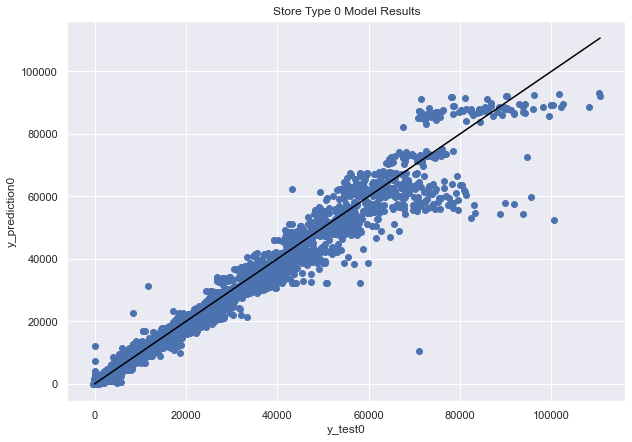

In [23]:
# Store Type 0
print('Store Type 0 Model Results')
print('R2 training score = ' + str(round(model0.score(X_train0, y_train0), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test0, y_pred0), 4)))
print('Root-mean-squared test score = ' + str(round(mean_squared_error(y_test0, y_pred0, squared=False))))

_ = plt.figure(figsize=(10, 7))
_ = plt.scatter(np.ravel(y_test0), y_pred0)
_ = plt.plot([1, y_test0.max()], [1, y_test0.max()], c='black')
plt.xlabel('y_test0')
plt.ylabel('y_prediction0')
plt.title('Store Type 0 Model Results')
_ = plt.show()

### Store Type 1 (B)

In [12]:
y_pred1 = model1.predict(X_test1)

Store Type 1 Model Results
R2 training score = 0.9371
R2 testing score = 0.8403
Root-mean-squared test score = 6329


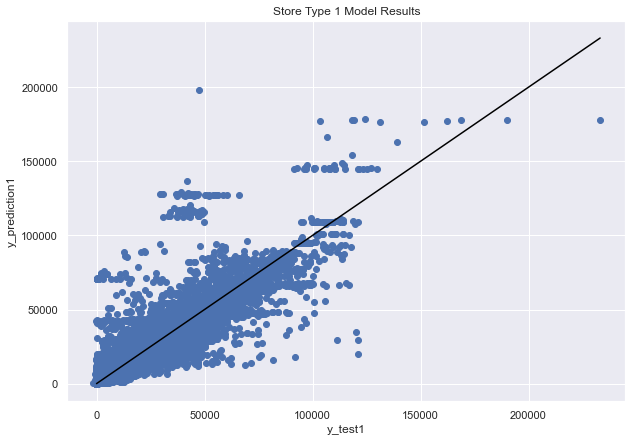

In [13]:
# Store Type 1
print('Store Type 1 Model Results')
print('R2 training score = ' + str(round(model1.score(X_train1, y_train1), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test1, y_pred1), 4)))
print('Root-mean-squared test score = ' + str(round(mean_squared_error(y_test1, y_pred1, squared=False))))

_ = plt.figure(figsize=(10, 7))
_ = plt.scatter(np.ravel(y_test1), y_pred1)
_ = plt.plot([1, y_test1.max()], [1, y_test1.max()], c='black')
plt.xlabel('y_test1')
plt.ylabel('y_prediction1')
plt.title('Store Type 1 Model Results')
_ = plt.show()

### Store Type 2 (A)

In [14]:
y_pred2 = model2.predict(X_test2)

Store Type 2 Model Results
R2 training score = 0.9934
R2 testing score = 0.937
Root-mean-squared test score = 6543


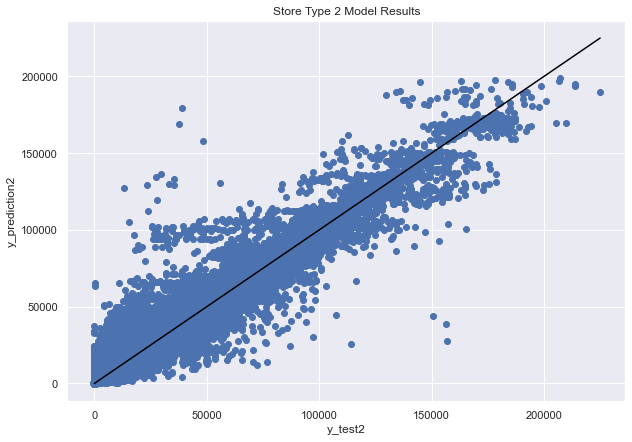

In [15]:
# Store Type 2

print('Store Type 2 Model Results')
print('R2 training score = ' + str(round(model2.score(X_train2, y_train2), 4)))
print('R2 testing score = ' + str(round(r2_score(y_test2, y_pred2), 4)))
print('Root-mean-squared test score = ' + str(round(mean_squared_error(y_test2, y_pred2, squared=False))))

_ = plt.figure(figsize=(10, 7))
_ = plt.scatter(np.ravel(y_test2), y_pred2)
_ = plt.plot([1, y_test2.max()], [1, y_test2.max()], c='black')
plt.xlabel('y_test2')
plt.ylabel('y_prediction2')
plt.title('Store Type 2 Model Results')
_ = plt.show()

### Export Final Metric Tables

In [16]:
FinalMetrics = pd.DataFrame({'Store Type':['0 (C)', '1 (B)', '2 (A)'], \
                             'R2 Score':['0.9787', '0.8403', '0.9370'], \
                             'RMSE Score':['$2,393', '$6,329', '$6,543']})

FinalMetrics.set_index('Store Type', inplace=True)

In [17]:
dfi.export(FinalMetrics, 'FinalMetrics.png')